# 구내식당 식수 인원 예측 AI
- 데이콘 혼자해보기
- 시각화도구(matplotlib, seaborn, plotly)
- 데이터분석도구(pandas, numpy)
- 머신러닝 도구(sklearn, RandomForestRegressor)

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



- 초기설정하기

## 프로세스
- 1.데이터셋 확인
- 2.탐색적 데이터 분석
- 3.feature engineering
- 4.model 만들기
- 5.모델 학습 및 예측 
- 6.모델 평가

## 1.데이터셋 확인

In [63]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['요일'] = train['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test['요일'] = test['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})

- smartnavy님 코드공유인용
- 출근한 사람들만 분류


- 데이터불러오기

In [64]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,출근
0,2016-02-01,0,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2401
1,2016-02-02,1,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2378
2,2016-02-03,2,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2365
3,2016-02-04,3,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2277
4,2016-02-05,4,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2142


- 데이터 확인

In [65]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,2,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021-01-28,3,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021-01-29,4,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021-02-01,0,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021-02-02,1,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


- 데이터 확인

In [66]:
submission.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


- 데이터 확인

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   일자              1205 non-null   object
 1   요일              1205 non-null   int64 
 2   본사정원수           1205 non-null   int64 
 3   본사휴가자수          1205 non-null   int64 
 4   본사출장자수          1205 non-null   int64 
 5   본사시간외근무명령서승인건수  1205 non-null   int64 
 6   현본사소속재택근무자수     1205 non-null   int64 
 7   조식메뉴            1205 non-null   object
 8   중식메뉴            1205 non-null   object
 9   석식메뉴            1205 non-null   object
 10  중식계             1205 non-null   int64 
 11  석식계             1205 non-null   int64 
 12  출근              1205 non-null   int64 
dtypes: int64(9), object(4)
memory usage: 122.5+ KB


In [68]:
train.describe()

,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식계,석식계,출근
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,2.003320,2807.815768,157.913693,241.142739,274.117012,43.506224,890.334440,461.772614,2365.253112
std,1.415384,171.264404,144.190572,43.532298,246.239651,109.937400,209.505057,139.179202,176.563062
min,0.000000,2601.000000,23.000000,41.000000,0.000000,0.000000,296.000000,0.000000,1372.000000
25%,1.000000,2645.000000,71.000000,217.000000,4.000000,0.000000,758.000000,406.000000,2281.000000
50%,2.000000,2760.000000,105.000000,245.000000,299.000000,0.000000,879.000000,483.000000,2357.000000
75%,3.000000,2962.000000,185.000000,272.000000,452.000000,0.000000,1032.000000,545.000000,2461.000000
max,4.000000,3305.000000,1224.000000,378.000000,1044.000000,533.000000,1459.000000,905.000000,2921.000000


- 이번 구내식당 식수 인원 조사 대회에서 feature는 본사정원수, 본사휴가자수, 본사출장자수, 본사시간외근무명령서승인건수, 현본사소속재택근무자수, 중식메뉴, 석식메뉴 입니다
- 예측할려는 target는 중식계, 석식계 입니다.

### 1.1 Nulldata Check

In [69]:
for col in train.columns:
    msg = 'column: {:>15}\t\t Percent of Nan value: {:.2f}%'.format(col, 100
* (train[col].isnull().sum() / train[col].shape[0]))
    print(msg)

column:              일자		 Percent of Nan value: 0.00%
column:              요일		 Percent of Nan value: 0.00%
column:           본사정원수		 Percent of Nan value: 0.00%
column:          본사휴가자수		 Percent of Nan value: 0.00%
column:          본사출장자수		 Percent of Nan value: 0.00%
column:  본사시간외근무명령서승인건수		 Percent of Nan value: 0.00%
column:     현본사소속재택근무자수		 Percent of Nan value: 0.00%
column:            조식메뉴		 Percent of Nan value: 0.00%
column:            중식메뉴		 Percent of Nan value: 0.00%
column:            석식메뉴		 Percent of Nan value: 0.00%
column:             중식계		 Percent of Nan value: 0.00%
column:             석식계		 Percent of Nan value: 0.00%
column:              출근		 Percent of Nan value: 0.00%


- 결측치 없음

In [70]:
for col in test.columns:
    msg = 'column: {:>15}\t\t Percent of Nan value: {:.2f}%'.format(col, 100
* (test[col].isnull().sum() / test[col].shape[0]))
    print(msg)

column:              일자		 Percent of Nan value: 0.00%
column:              요일		 Percent of Nan value: 0.00%
column:           본사정원수		 Percent of Nan value: 0.00%
column:          본사휴가자수		 Percent of Nan value: 0.00%
column:          본사출장자수		 Percent of Nan value: 0.00%
column:  본사시간외근무명령서승인건수		 Percent of Nan value: 0.00%
column:     현본사소속재택근무자수		 Percent of Nan value: 0.00%
column:            조식메뉴		 Percent of Nan value: 0.00%
column:            중식메뉴		 Percent of Nan value: 0.00%
column:            석식메뉴		 Percent of Nan value: 0.00%


- 두 데이터 다 결측치가 없습니다.

### 2.1 시각화

#### 출근분류

In [71]:
def chulgeun(x):
    if x < 2150:
        return 21.5
    elif x < 2200:
        return 22    
    elif x < 2250:
        return 22.5 
    elif x < 2300:
        return 23 
    elif x < 2350:
        return 23.5 
    elif x < 2400:
        return 24 
    elif x < 2450:
        return 24.5 
    elif x < 2500:
        return 25
    elif x < 2550:
        return 25.5
    else:
        return 26   
    
train['출근분류'] = train['출근'].apply(chulgeun)

- 출근분류하기

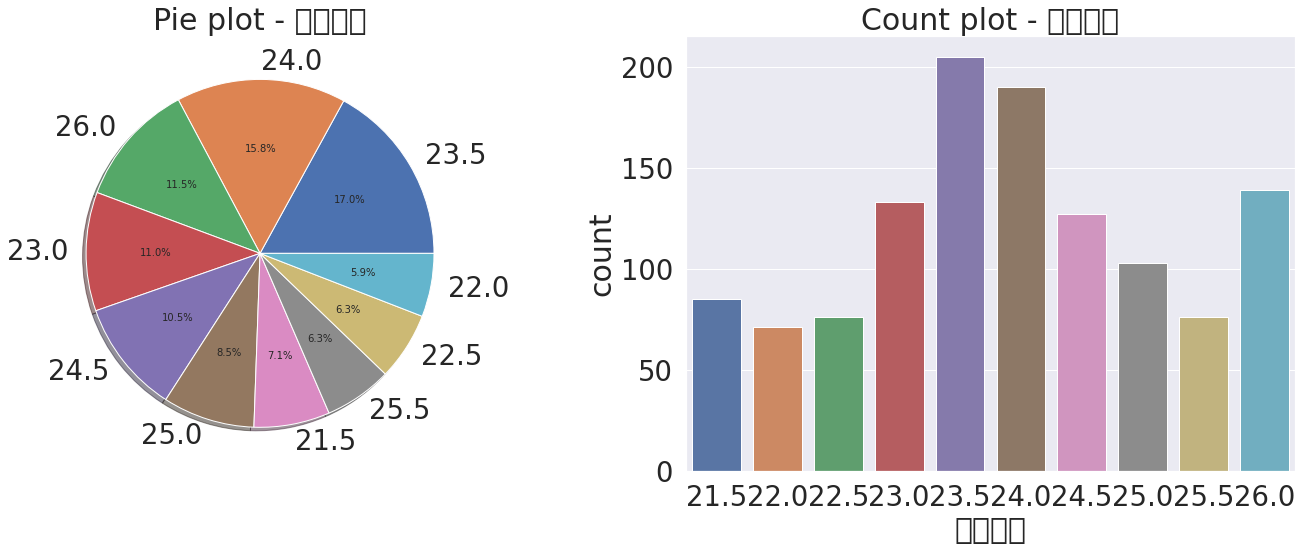

In [72]:
f, ax = plt.subplots(1, 2, figsize=(24, 8))

train['출근분류'].value_counts().plot.pie( autopct='%1.1f%%',ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - 출근분류')
ax[0].set_ylabel('')
sns.countplot('출근분류', data=train, ax= ax[1])
ax[1].set_title('Count plot - 출근분류')

plt.show()

- 분석
 - 23.5와 24.0의 값이 높은데 값의 합은 2300명 이상 2400명 이하이다

#### 출근분류와 중식계의 관계성

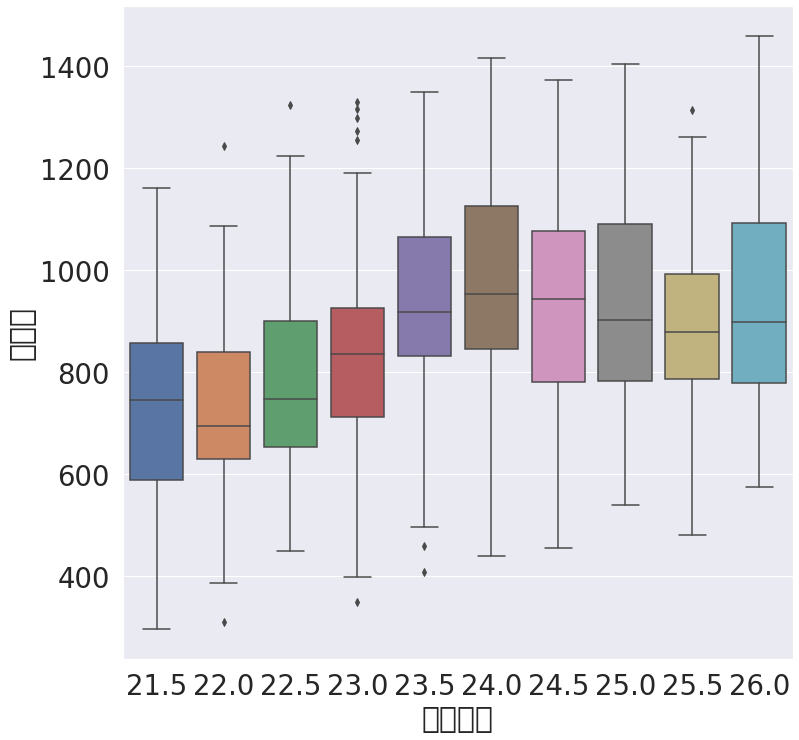

In [73]:
plt.figure(figsize=(12,12))
sns.boxplot(train['출근분류'], train['중식계'])

- 분석
 - 23.5까지 증가하며 그 이후로는 큰 차이가 없다

#### 출근분류와 석식계의 관계성

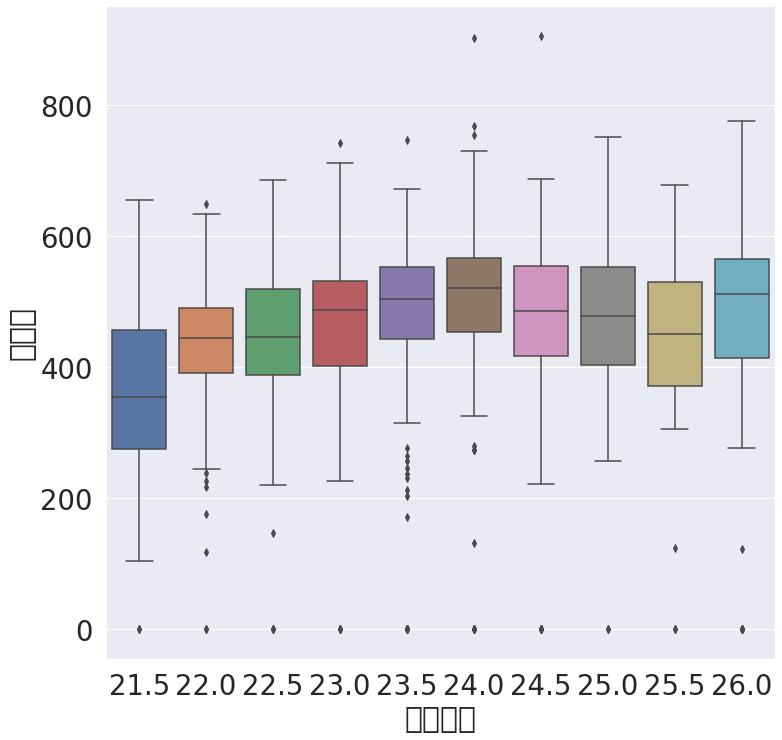

In [74]:
plt.figure(figsize=(12,12))
sns.boxplot(train['출근분류'], train['석식계'])

- 분석
 - 출근한 숫자에 따라 동등하게 상승하며, 24부터는 거의 상승하지않는다

#### 본사시간외근무명령서승인건수와 석식계의 관계성

In [75]:
def yageun(x):
    if x < 50:
        return 0
    elif x < 100:
        return 1    
    elif x < 200:
        return 2
    elif x < 300:
        return 3
    elif x < 400:
        return 4
    elif x < 500:
        return 5
    elif x < 600:
        return 6
    elif x < 700:
        return 7
    else:
        return 8    
    
train['야근함'] = train['본사시간외근무명령서승인건수'].apply(yageun)

- 야근분류

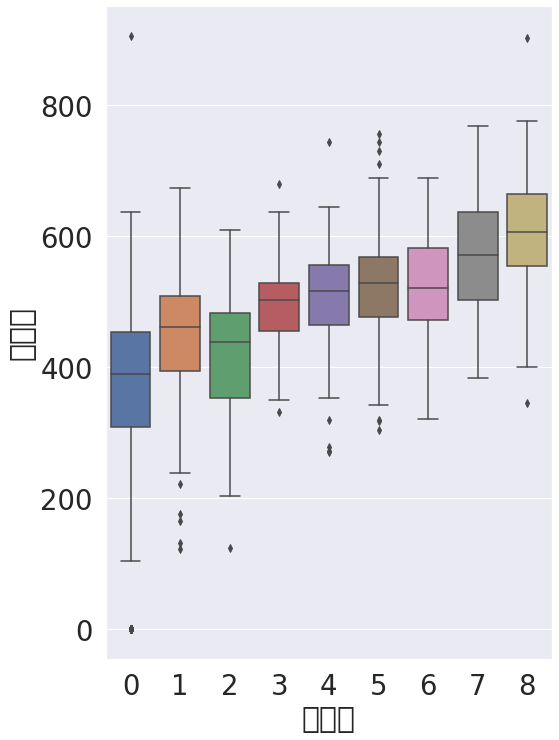

In [76]:
plt.figure(figsize=(8,12))
sns.boxplot(train['야근함'], train['석식계'])

- 분석
 - 야근 인원이 많아질수록 석식계가 증가한다.

#### 요일과 야근의 관계성

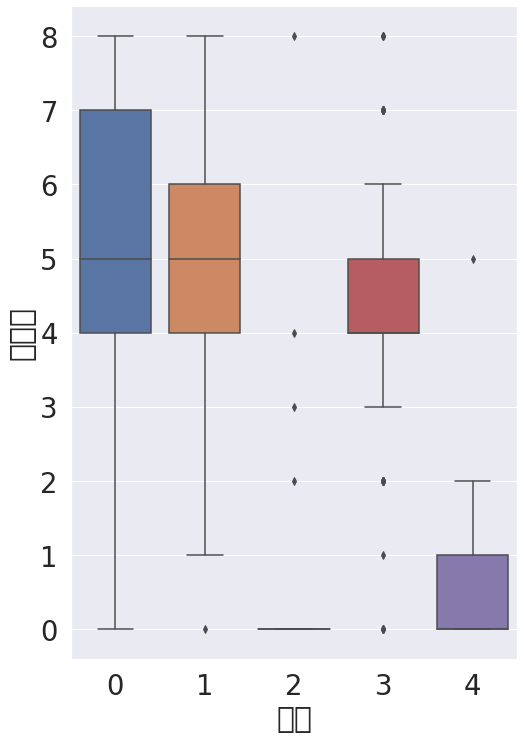

In [77]:
plt.figure(figsize=(8,12))
sns.boxplot(train['요일'], train['야근함'])

- 분석
 - 수요일엔 야근이 거의 없음

#### 요일과 중식계의 관계성

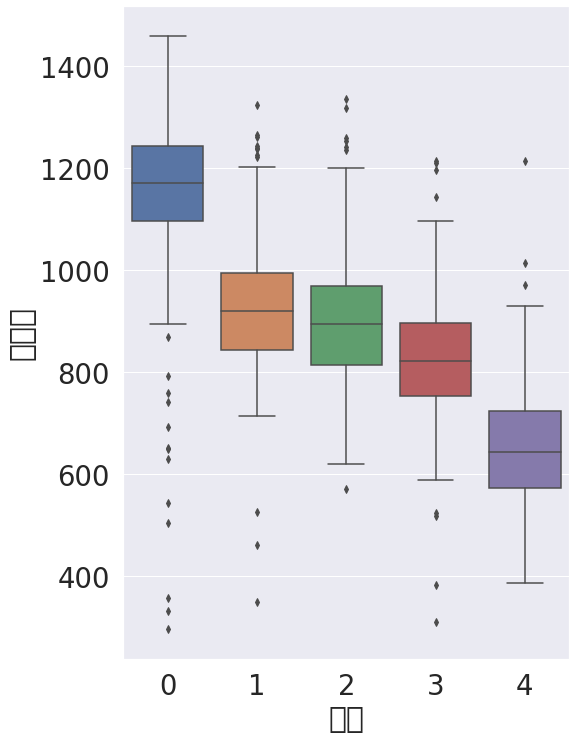

In [78]:
plt.figure(figsize=(8,12))
sns.boxplot(train['요일'], train['중식계'])

- 분석
 - 요일이 올라갈 수록 중식계의 수는 줄어든다
 - 월요일의 중식계가 상대적으로 높다.
 - 금요일의 중식계가 상대적으로 낮다.

#### 요일과 석식계, 야근함의 관계성

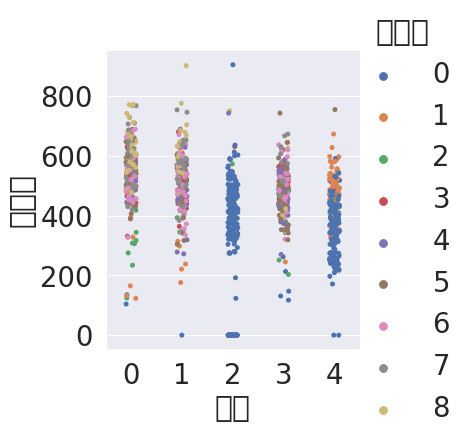

In [79]:
sns.catplot('요일', '석식계', hue='야근함', data=train)

- 분석
 - 수요일과 금요일은 야근과 상관없이 석식을 먹는다는 것을 확인
  - 그러므로 특식이 나올 수도 있겠다.
- 밑에서 더 자세히 알아보자

#### 요일과 야근함의 관계성

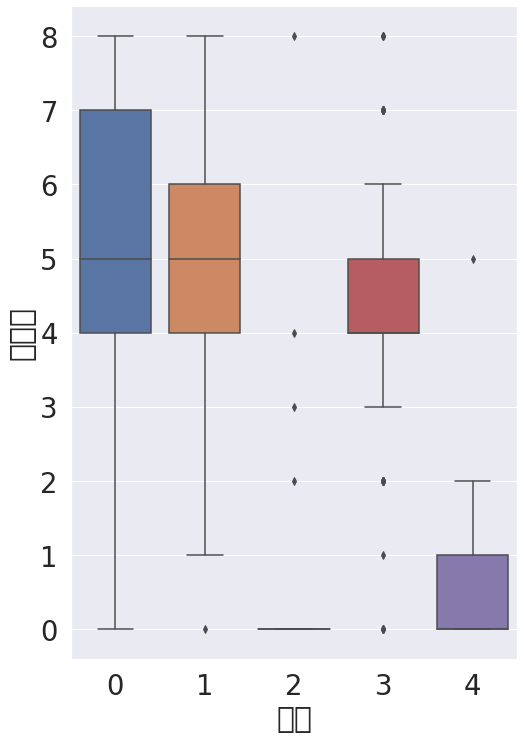

In [80]:
plt.figure(figsize=(8,12))
sns.boxplot(train['요일'], train['야근함'])

- 분석
 - 야근하는 사람이 2(수), 4(금)은 매우 적다.
 - 그러므로 수,금은 야근과 상관없이 석식계가 높게 나온다.

#### 야근함과 석식계의 관계성

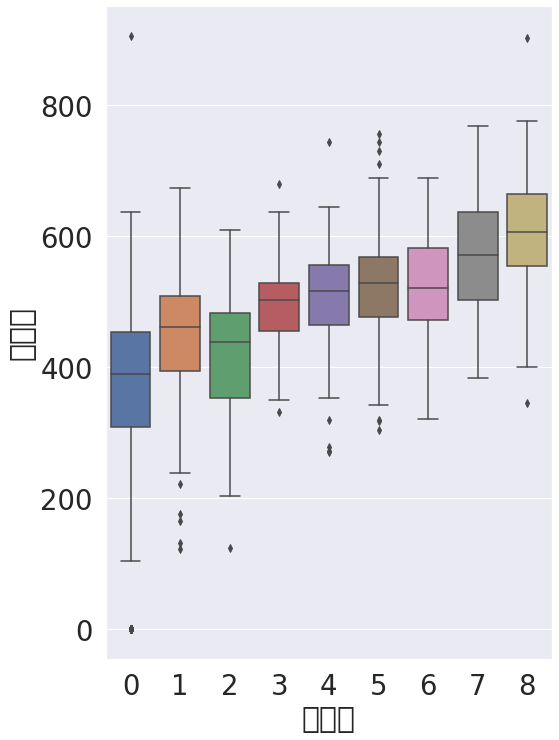

In [81]:
plt.figure(figsize=(8,12))
sns.boxplot(train['야근함'], train['석식계'])

- 분석
 - 야근하는 인원수와 석식계는 비례한다.
 - 하지만 앞의 관계성에서 보았듯이 수, 금에는 큰 영향을 주지 못한다.

## Model만들기
- 일단 알려진 정보를 가지고 모델을 만들어 보겠습니다.
- 모델은 RandomForestRegressor 사용

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split


x_train = train[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
y1_train = train['중식계']
y2_train = train['석식계']

x_test = test[['요일', '본사정원수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']]
X_tr, X_vld, y_tr, y_vld = train_test_split(x_train, y1_train, test_size=0.2)

- 베이스라인을 인용

In [83]:
model1 = RandomForestRegressor(n_jobs=-1, random_state=42)
model2 = RandomForestRegressor(n_jobs=-1, random_state=42)

- 베이스라인 인용

#### 모델 학습하기

In [84]:
model1.fit(x_train, y1_train)
model2.fit(x_train, y2_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

#### 추론하기


In [85]:
pred1 = model1.predict(x_test)
pred2 = model2.predict(x_test)

#### 결과 제출

In [86]:
submission['중식계'] = pred1
submission['석식계'] = pred2

In [87]:
submission.to_csv('baseline.csv', index=False)

### 후기
 - 혼자서 해보니 분석이 분석같지도 않고 분류도 어렵고 합니다.
 - 제 레벨을 알게된 것 같고 다시 예제 분석을 해보겠습니다.
 - 간간히 코드도 수정하겠습니다.